In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import RegularGridInterpolator
import time

import sys
sys.path.append('../')

from adasubtraction.waveeqmod import Acoustic2DDevito

plt.style.use('default')

In [2]:
nx, nz = 751, 751 # grid 
dx, dz = 4, 2
origin = (0., 0.) 

shape = (nx, nz) 
spacing = (dx, dz)

In [3]:
rows = nz
cols = nx
top_thickness = 70  # 顶部地层厚度（0-30行）
base_interface = 400  # 基准分界面位置
amplitude = 30       # 正弦波振幅
period = 200         # 正弦波周期

v = np.full((rows, cols), 1300.0)

# 填充顶部地层 (0-30行)
v[:top_thickness, :] = 1000.0

# 生成分界面曲线
x_coords = np.arange(cols)
interface = base_interface - amplitude * np.sin(2 * np.pi * x_coords / period)

# 创建网格索引
row_indices = np.arange(rows)[:, np.newaxis]  # 行索引 (181,1)

# 构建掩码：3500 m/s区域 (31行 <= 当前行 <= 分界面)
mask = (row_indices >= top_thickness) & (row_indices <= interface)

# 填充中间层
v[mask] = 1200

v[70:250, :] = 1100
v[-200:-100, :] = 1400
v[-100:, :] = 1500

In [4]:
v_dw = 1000 * np.ones_like(v)
v_dw[-1, -1] = 1500

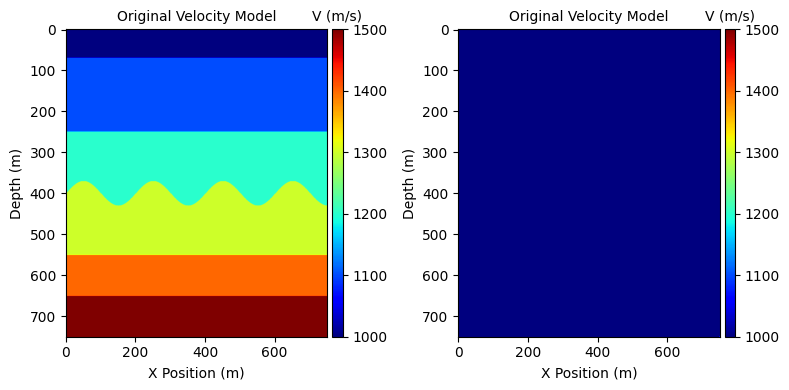

In [5]:
# Create figure
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

im0 = axs[0].imshow(v, cmap='jet')
axs[0].axis('tight')
axs[0].set_title('Original Velocity Model', fontsize=10)
axs[0].set_ylabel('Depth (m)', fontsize=10)
axs[0].set_xlabel('X Position (m)', fontsize=10)
divider = make_axes_locatable(axs[0])

cax = divider.append_axes('right', size='4%', pad=0.05)
cax.set_title('V (m/s)', fontsize=10)
cax.tick_params(labelsize=10)
fig.colorbar(im0, cax=cax, orientation='vertical')
fig.colorbar(im0, cax=cax, orientation='vertical')

im1 = axs[1].imshow(v_dw, cmap='jet')
axs[1].axis('tight')
axs[1].set_title('Original Velocity Model', fontsize=10)
axs[1].set_ylabel('Depth (m)', fontsize=10)
axs[1].set_xlabel('X Position (m)', fontsize=10)
divider = make_axes_locatable(axs[1])

cax = divider.append_axes('right', size='4%', pad=0.05)
cax.set_title('V (m/s)', fontsize=10)
cax.tick_params(labelsize=10)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [6]:
nbl = 300
space_order = 6
t0 = 0
dt = 4 # ms
nt = nz
f0 = 25 # Hz
fs = True # 上表面自由边界
nsrc = nx // 2
nrec = nx
depth = 5

In [7]:
awe_free = Acoustic2DDevito()

# 速度模型
awe_free.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v.T,                     # 速度模型（需要转置以匹配内部坐标格式）
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs                  # 是否设置自由表面条件（True 表示有自由表面）
)


# 创建几何布置
awe_free.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0] * 2,      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=dt*nt,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)

print(awe_free.geometry.dt)

Operator `initdamp` ran in 0.01 s


0.709


In [8]:
awe_damp = Acoustic2DDevito()

# 速度模型
fs_damp = False
awe_damp.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v.T,                     # 速度模型（需要转置以匹配内部坐标格式）
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs_damp             # 是否设置自由表面条件（True 表示有自由表面）
)


# 创建几何布置
awe_damp.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0] * 2,      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=dt*nt,                                   # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)


print(awe_damp.geometry.dt)

Operator `initdamp` ran in 0.01 s


0.709


In [9]:
awe_free_dw = Acoustic2DDevito()

awe_free_dw.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v_dw,                  # 速度模型
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs                  # 是否设置自由表面条件（True 表示有自由表面）
)

awe_free_dw.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0] * 2,      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=dt*nt,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)

print(awe_free_dw.geometry.dt)

Operator `initdamp` ran in 0.01 s


0.709


In [10]:
awe_damp_dw = Acoustic2DDevito()


awe_damp_dw.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v_dw,                  # 速度模型
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs_damp                  # 是否设置自由表面条件（True 表示有自由表面）
)

awe_damp_dw.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0] * 2,      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=dt*nt,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)

print(awe_damp_dw.geometry.dt)

Operator `initdamp` ran in 0.01 s


0.709


In [11]:
isrc = nsrc // 2 + 1

data_free, _, _ = awe_free.solve_one_shot(isrc, dt=dt)
data_free = data_free.data

data_damp, _, _ = awe_damp.solve_one_shot(isrc, dt=dt)
data_damp = data_damp.data

data_free.shape

Operator `Forward` ran in 5.66 s
Operator `Forward` ran in 6.95 s


(753, 751)

In [12]:
data_damp = data_damp[:751, :]
data_free = data_free[:751, :]

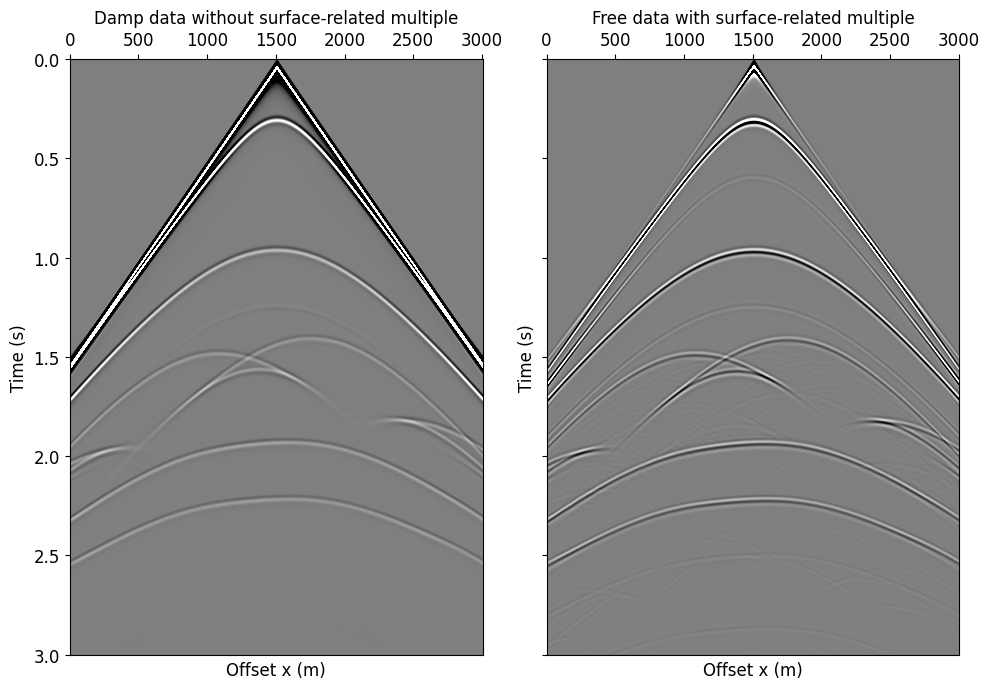

In [13]:
vmax = 1e-2
vmin = -vmax

fig, axs = plt.subplots(1, 2, figsize=(10, 7),sharey=True)

axs[0].imshow(data_damp, aspect='auto', vmin=vmin, vmax=vmax, 
              extent=[0, nx*dx, data_free.shape[0] * dt * 1e-3, 0], cmap='grey')
axs[0].set_title('Damp data without surface-related multiple',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].imshow(data_free, aspect='auto', vmin=vmin, vmax=vmax, 
              extent=[0, nx*dx, data_free.shape[0] * dt * 1e-3, 0], cmap='grey')
axs[1].set_title('Free data with surface-related multiple',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].set_ylabel('Time (s)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
axs[0].xaxis.set_ticks_position('top')
axs[1].xaxis.set_ticks_position('top')

In [14]:
dw_free, _, _ = awe_free_dw.solve_one_shot(isrc, dt=dt)
dw_free = dw_free.data
dw_free = dw_free[:751, :]

dw_damp, _, _ = awe_damp_dw.solve_one_shot(isrc, dt=dt)
dw_damp = dw_damp.data
dw_damp = dw_damp[:751, :]

data_free -= dw_free
data_damp -= dw_damp

Operator `Forward` ran in 5.63 s
Operator `Forward` ran in 6.76 s


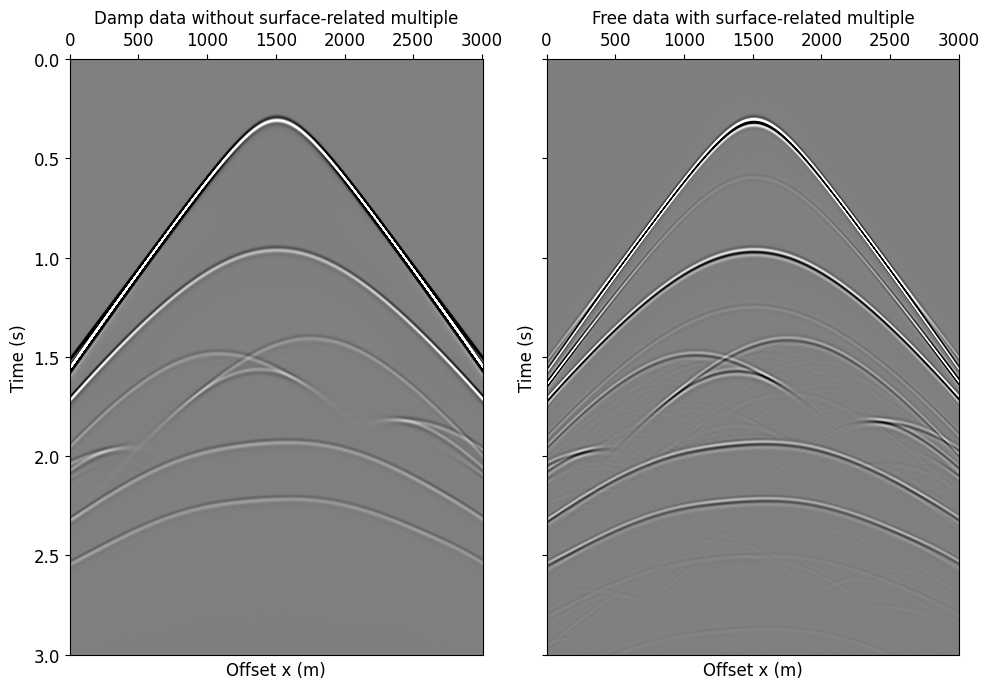

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7),sharey=True)

axs[0].imshow(data_damp, aspect='auto', vmin=vmin, vmax=vmax, 
              extent=[0, nx*dx, data_free.shape[0] * dt * 1e-3, 0], cmap='grey')
axs[0].set_title('Damp data without surface-related multiple',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].imshow(data_free, aspect='auto', vmin=vmin, vmax=vmax, 
              extent=[0, nx*dx, data_free.shape[0] * dt * 1e-3, 0], cmap='grey')
axs[1].set_title('Free data with surface-related multiple',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].set_ylabel('Time (s)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
axs[0].xaxis.set_ticks_position('top')
axs[1].xaxis.set_ticks_position('top')

In [16]:
start_time = time.time()/60

data_free, _ = awe_free.solve_all_shots(dt=dt, savedtot=True)
data_free = data_free[:, :, :751]

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

100%|██████████| 375/375 [1:10:17<00:00, 11.25s/it]


--- 70.319 minutes ---


In [17]:
start_time = time.time()/60

dw_free, _ = awe_free_dw.solve_all_shots(dt=dt, savedtot=True)
dw_free = dw_free[:, :, :751]

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

100%|██████████| 375/375 [1:06:31<00:00, 10.64s/it]


--- 66.532 minutes ---


In [18]:
data_free_syn2 = data_free - dw_free
np.savez('../data/data_free_syn2.npz', data_free_syn2)

In [19]:
start_time = time.time()/60

data_damp, _ = awe_damp.solve_all_shots(dt=dt, savedtot=True)
data_damp = data_damp[:, :, :751]

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

100%|██████████| 375/375 [1:23:33<00:00, 13.37s/it]


--- 83.571 minutes ---


In [20]:
start_time = time.time()/60

dw_damp, _ = awe_damp_dw.solve_all_shots(dt=dt, savedtot=True)
dw_damp = dw_damp[:, :, :751]

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

100%|██████████| 375/375 [1:20:29<00:00, 12.88s/it]


--- 80.513 minutes ---


In [21]:
data_damp_syn2 = data_damp - dw_damp
np.savez('../data/data_damp_syn2.npz', data_damp_syn2)